In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from dowhy import CausalModel
from econml.dml import LinearDML
import matplotlib.pyplot as plt



/home/lpanjal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
data = pd.read_csv("toy_llm_bias_data.csv")

data

# Binarize or categorize gender and appearance for simplicity
data['gender'] = data['gender'].map({'male': 0, 'female': 1})  # Binary encoding
data['context_complexity'] = data['context_complexity'].map({'low':0, 'medium' : 1, 'high' : 2})
data['appearance'] = data['appearance'].apply(lambda x: 0 if x in ['plain', 'average'] else 1)  # Simplified

# 2. Define the Treatment, Outcome, and Confounders
treatment = ["gender", "appearance"]
outcomes = ["regard_score", "toxicity_score"]
confounders = ["prompt_length", "context_complexity"]  # Example confound

In [11]:
data

,gender,appearance,prompt_length,context_complexity,regard_score,toxicity_score,prompt
0,0,1,37,1,0.296510,0.214589,Prompt 0
1,1,0,37,0,0.419781,0.377259,Prompt 1
2,0,0,29,2,0.256207,0.038963,Prompt 2
3,0,0,39,0,0.611514,0.618254,Prompt 3
4,0,0,20,1,0.081594,0.336554,Prompt 4
...,...,...,...,...,...,...,...
95,1,0,28,0,0.625940,0.400223,Prompt 95
96,1,0,25,2,0.820427,0.477715,Prompt 96
97,1,0,12,1,0.651485,0.082891,Prompt 97
98,1,0,29,2,0.206684,0.528370,Prompt 98


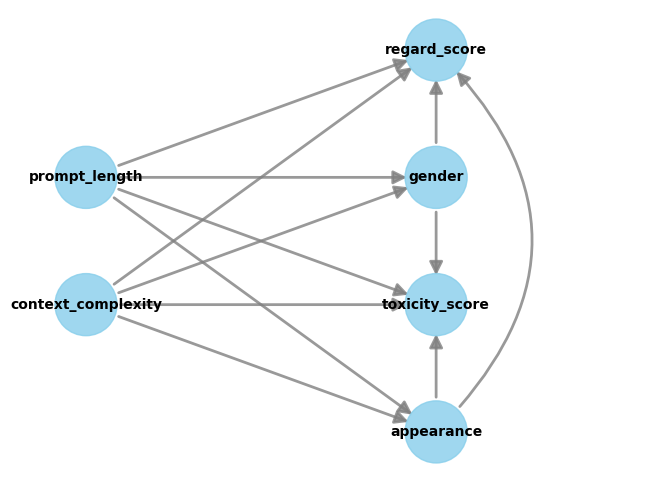

In [12]:
model = CausalModel(
    data=data,
    treatment=treatment,
    outcome=outcomes,
    common_causes=confounders
)

# Generate and visualize a DAG
graph = model.view_model()
plt.show()


In [14]:
# 4. Identify the Causal Effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified Estimand:", identified_estimand)

# 5. Estimate the Causal Effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
)
print("Causal Effect Estimate:", estimate)

Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                            
─────────────────────(E[regard_score|context_complexity,prompt_length])
d[gender  appearance]                                                  
Estimand assumption 1, Unconfoundedness: If U→{gender,appearance} and U→regard_score then P(regard_score|gender,appearance,context_complexity,prompt_length,U) = P(regard_score|gender,appearance,context_complexity,prompt_length)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal Effect Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                            
─────────────────────(E[regard_score|co

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [20]:
X = data[confounders].values  # Features
T = data[treatment].values  # Treatment Variables
Y = data[outcomes].values  # Outcome Scores

# Double Machine Learning (DML) for more robust causal effect estimation
dml = LinearDML(model_y='linear', model_t='linear', random_state=42)
dml.fit(Y, T, X=X)
effects = dml.effect(X)
print("Causal Effects with DML:", effects)


Causal Effects with DML: [[ 0.07458161 -0.14212232]
 [ 0.01665493 -0.13144752]
 [ 0.20594419 -0.10023864]
 [-0.00170404 -0.14458714]
 [ 0.23063291 -0.03043553]
 [ 0.07458161 -0.14212232]
 [ 0.16004674 -0.13308769]
 [-0.02639277 -0.21439024]
 [-0.02924251 -0.16429658]
 [ 0.38035447  0.02458778]
 [ 0.02583442 -0.12487771]
 [ 0.15434726 -0.03290035]
 [ 0.30406882  0.02212296]
 [-0.02639277 -0.21439024]
 [ 0.27653036  0.00241352]
 [ 0.25817138 -0.0107261 ]
 [ 0.08376109 -0.13555251]
 [ 0.30691856 -0.02797071]
 [-0.06596046 -0.19057582]
 [-0.02924251 -0.16429658]
 [ 0.05337289 -0.10516827]
 [ 0.13598829 -0.04603997]
 [ 0.03786365 -0.16840157]
 [-0.02006302 -0.15772676]
 [ 0.16922623 -0.12651788]
 [ 0.2793801  -0.04768015]
 [-0.08431944 -0.20371544]
 [ 0.25532164  0.03936757]
 [ 0.36199549  0.01144816]
 [ 0.04989288 -0.21192543]
 [ 0.17555598 -0.0698544 ]
 [ 0.37117498  0.01801797]
 [ 0.31324831  0.02869277]
 [ 0.07458161 -0.14212232]
 [ 0.12047905 -0.10927327]
 [-0.00803379 -0.20125062]
 [ 

A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.


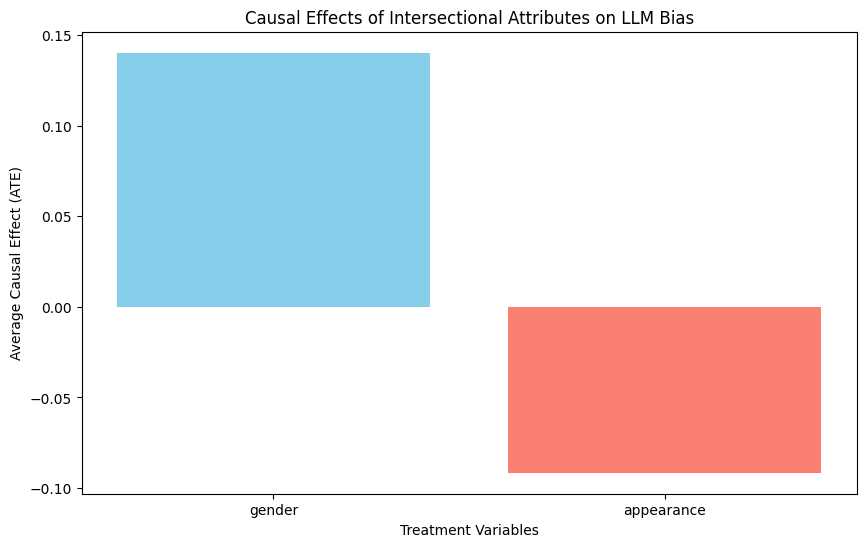

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(treatment, effects.mean(axis=0), color=['skyblue', 'salmon'])
plt.xlabel("Treatment Variables")
plt.ylabel("Average Causal Effect (ATE)")
plt.title("Causal Effects of Intersectional Attributes on LLM Bias")
plt.show()


In [22]:
sensitivity_analysis = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print("Sensitivity Analysis Result:", sensitivity_analysis)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Sensitivity Analysis Result: Refute: Add a random common cause
Estimated effect:0.10025142491189598
New effect:0.10138246055910673
p value:0.94



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con